# Исследование для магазина продуктов питания

В ходе нашего исследования нам нужно разобраться, как ведут себя пользователи мобильного приложения магазина продуктов питания и какой шрифт для приложения более привлекательный для наших клиентов. Для теста пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 

**Цель исследования** – выяснить, какой шрифт для приложения лучше: привычный для пользователя или новый.

**Ход исследования:**
1. Ознакомимся с данными.
2. Проведем предобработку данных и подготовм их к анализу.
3. Изучим и проверим данные. Узнаем, сколько всего событий и пользователей в логе, сколько в среднем событий приходится на пользователя. Посмотрим, данными за какой период мы располагаем и много ли событий и пользователей потеряем, отбросив старые данные. Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.
4. Изучим воронку событий. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
5. Исследуем результаты A/A/B-эксперимента.
6. Сделаем общие выводы и вынесем рекомендации.

**Описание данных:**\
\
*Файл /datasets/logs_exp.csv (информация о логах)*\
\
`EventName` — название события;\
`DeviceIDHash` — уникальный идентификатор пользователя;\
`EventTimestamp` — время события;\
`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


## 1. Откроем файл с данными и изучим общую информацию

**Импортируем библиотеки, необходимые для исследования**

In [1]:
# настроим нашу тетрадку так, чтобы все графики были картинками (пригодится для github)
%pip install -U kaleido -q
import plotly.io as pio
pio.renderers.default = "png"

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import scipy.stats as stats
import plotly.express as px
from plotly import graph_objects as go
import math as mth
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

Note: you may need to restart the kernel to use updated packages.


**Откроем датафрэйм с данными**

In [2]:
data = pd.read_csv('/Users/polinamokretsova/logs_exp.csv', sep='\t')
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


**Посмотрим общую информацию о данных**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Мы изучили данные и вот, что выяснили:**
* Названия столбцов не приведены к нижнему регистру и неудобны для использования.
* У столбца с датой некорректный тип данных.

В следующем шаге мы проработаем каждый из этих пунктов и подготовим данные к анализу.

## 2. Проведем предобработку данных и подготовм их к анализу

**Заменим названия столбцов на удобные для использования в ходе анализа**

In [4]:
# приведем названия столбцов к нижнему регистру в датафрэйме orders
data.rename(columns={"EventName": "event_name", "DeviceIDHash": "device_id",\
                     "EventTimestamp": "event_timestamp", "ExpId": "exp_id"}, inplace = True)
data.head()

,event_name,device_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Добавим столбцы с датой и временем и отдельно с датой. Изменим тип данных на временной**

In [5]:
data['date_time'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['date'] = data['date_time'].astype('datetime64[D]')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id        244126 non-null  int64         
 2   event_timestamp  244126 non-null  int64         
 3   exp_id           244126 non-null  int64         
 4   date_time        244126 non-null  datetime64[ns]
 5   date             244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


**Проверим данные на пропущенные значения**

In [7]:
data.isna().sum()

event_name         0
device_id          0
event_timestamp    0
exp_id             0
date_time          0
date               0
dtype: int64

**Проверим данные на дубликаты**

In [8]:
data.duplicated().sum()

413

**Удалим дубликаты**\
\
Мы обнаружили 413 дубликатов в наших данных. Скорее всего они попали по ошибке, и мы заметили некорректное поведение пользователя. Целесообразно будет удалить эти данные.

In [9]:
data = data.drop_duplicates().reset_index(drop=True)
data.head()

,event_name,device_id,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


**Мы провели предобработку данных:**
* Привели названия столбцов к нижнему регистру, переименовали их для удобства.
* Добавили столбцы с датой и временем и отдельно с датой, изменили тип данных на временной.
* Мы выяснили, что в данных нет пропусков, но есть дубликаты. Дубликаты удалили, посчитав эти данные некорректными.

Данные готовы, можно приступать к анализу.

## 3. Изучим и проверим данные

**Узнаем, сколько всего событий в логе**

In [10]:
print('Всего событий: %d, типов событий: %d.' % (data.shape[0], data['event_name'].nunique()))

Всего событий: 243713, типов событий: 5.


**Узнаем, сколько всего уникальных пользователей в логе**

In [11]:
print('Всего уникальных пользователей в логе: %d.' % (data['device_id'].nunique()))

Всего уникальных пользователей в логе: 7551.


**Узнаем, сколько в среднем событий приходится на пользователя**

In [12]:
events_per_user = data.groupby('device_id')['event_name'].count()\
                      .to_frame()\
                      .rename(columns={'event_name': 'total_events'})\
                      .reset_index()

events_per_user['total_events'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: total_events, dtype: float64

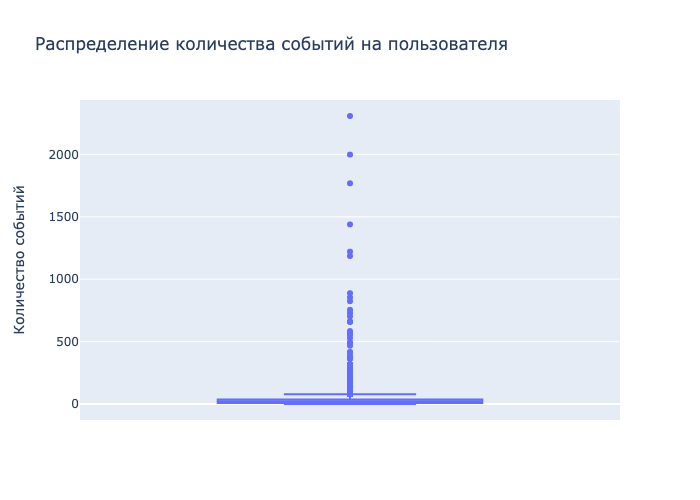

In [13]:
# визуализируем распределение событий с помощью диаграммы рассеяния
fig = px.box(events_per_user, y="total_events", title='Распределение количества событий на пользователя')
fig.update_yaxes(title_text='Количество событий')
fig.show()

В среднем на пользователя приходится 32 события. Но в наших данных много выбросов. Например, максимальное количество событий 2307 вызывает сомнения, что пользователь за 2 недели совершил столько действий. Посмотрим, сколько событий будет приходится на пользователей, если мы установим верхнюю границу в 500 событий.

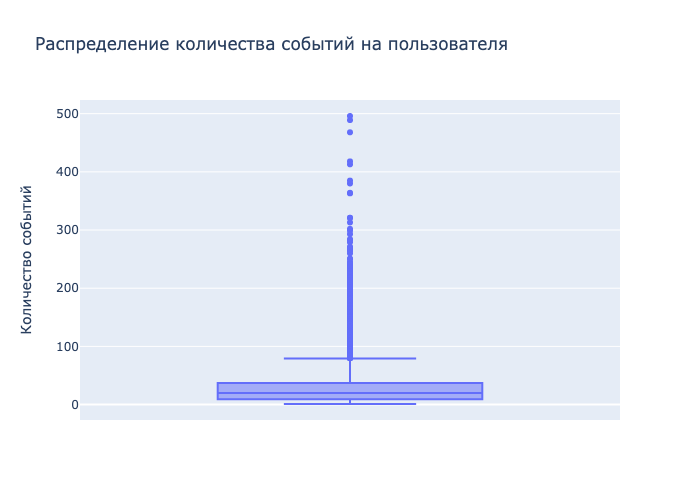

In [14]:
events_per_user = events_per_user[events_per_user['total_events'] <= 500]
fig = px.box(events_per_user, y="total_events", title='Распределение количества событий на пользователя')
fig.update_yaxes(title_text='Количество событий')
fig.show()

In [15]:
events_per_user['total_events'].describe()

count    7532.000000
mean       29.849177
std        35.414848
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max       496.000000
Name: total_events, dtype: float64

В среднем на пользователя прихолится 30 событий.

**Узнаем, данными за какой период мы располагаем. Найдём максимальную и минимальную дату**

In [16]:
dt_max = data['date_time'].max()
dt_min = data['date_time'].min()
print('Максимальная дата:', dt_max)
print('Минимальная дата:', dt_min)

Максимальная дата: 2019-08-07 21:15:17
Минимальная дата: 2019-07-25 04:43:36


In [17]:
period = dt_max - dt_min
print('Мы располагаем данными за период:', period)

Мы располагаем данными за период: 13 days 16:31:41


**Построим гистограмму по дате и времени**

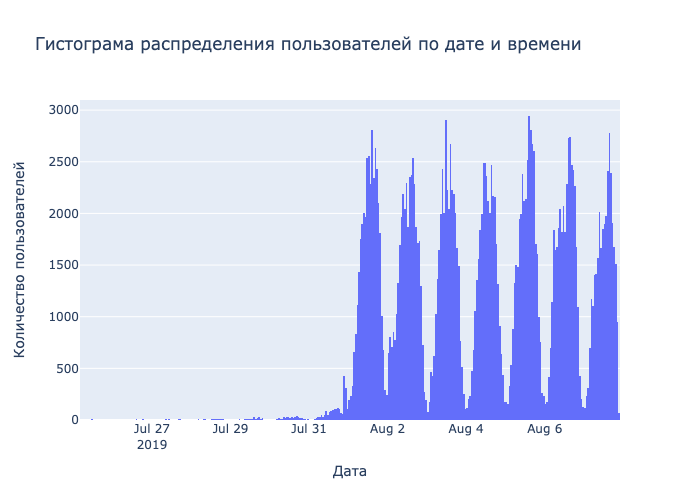

In [18]:
# построим гистограму распределения пользователей по дате и времени
fig = px.histogram(data, x='date_time', title='Гистограма распределения пользователей по дате и времени')
fig.update_xaxes(title_text='Дата') 
fig.update_yaxes(title_text='Количество пользователей')
fig.show()

По графику видно, что мы не имеем одинаково полные данные за весь период. **Оставим данные за период: 1-7 августа 2019 года.**


In [19]:
filter_data = data[data['date'] > '2019-07-31']

**Узнаем, много ли событий и пользователей вы потеряли, отбросив старые данные**

In [20]:
events = data.shape[0]
filter_events = filter_data.shape[0]
print(f'Было событий до очистки данных = {events}. Стало после очистки = {filter_events}') 
print(f'На сколько уменьшилось количество событий = {events-filter_events}. Потяря в процентах = {round((events-filter_events)/events*100,2)}%')

Было событий до очистки данных = 243713. Стало после очистки = 240887
На сколько уменьшилось количество событий = 2826. Потяря в процентах = 1.16%


In [21]:
users = data['device_id'].nunique()
filter_users = filter_data['device_id'].nunique()
print(f'Было пользователей до очистки данных = {users}. Стало после очистки = {filter_users}') 
print(f'На сколько уменьшилось количество пользователей = {users-filter_users}. Потяря в процентах = {round((users-filter_users)/users*100,2)}%')

Было пользователей до очистки данных = 7551. Стало после очистки = 7534
На сколько уменьшилось количество пользователей = 17. Потяря в процентах = 0.23%


In [22]:
print('В среднем событий на пользователя до очистки данных: %d.' % (data.shape[0]/data['device_id'].nunique()))
print('В среднем событий на пользователя после очистки данных: %d.' % (filter_data.shape[0]/filter_data['device_id'].nunique()))

В среднем событий на пользователя до очистки данных: 32.
В среднем событий на пользователя после очистки данных: 31.


Как мы видим, разница между очищенными и "сырыми" данными небольшая. Потяря событий в процентах составила = 1.16%, а потеря пользователей – 0,23%.

**Проверим, что у нас есть пользователи из всех трёх экспериментальных групп**

In [23]:
filter_data['exp_id'].unique()

array([246, 247, 248])

В каждой из групп примерно одинаковое количество пользователей. Проверим, нет ли таких пользователей, которые попали в несколько групп теста? 

In [24]:
users246 = filter_data[filter_data['exp_id']=='246']['device_id']
users247 = filter_data[filter_data['exp_id']=='247']['device_id']
users248 = filter_data[filter_data['exp_id']=='248']['device_id']

# а теперь посмотрим, есть ли одни и те же пользователи, которые попали в несколько групп сразу
all_users = filter_data.loc[filter_data['device_id'].isin(users246)& filter_data['device_id'].isin(users247)& filter_data['device_id'].isin(users248),'device_id'].unique()
print(len(all_users))

0


Таких пользователей нет. Группы сформированы корректно.

**Мы изучили и проверили данные. Вот, что нам удалось выяснить:**
* Данные за все даты нам не нужны, так как у нас не одинаково полные данные за весь период. Мы оставили данные за первую неделю августа: 1 - 7 августа 2019 года.
* Отбросив данные, которые не попали в этот период, мы потеряли совсем не много данных и это не страшно. При этом количество типов событий не изменилось - так же, как и в "сырых" данных у нас остались все 5 типов событий.
* Мы проверили и убедились в том, что у нас есть пользователи из всех трёх экспериментальных групп. Они практически равно распределены по группам и нет таких пользователей, которые бы попали в несколько групп одновременно.

## 4. Изучим воронку событий

**Посмотрим, какие события есть в логах и как часто они встречаются**

In [25]:
filter_data.groupby('event_name')\
           .agg({'device_id':'count'})\
           .reset_index()\
           .sort_values(by='device_id', ascending=False)\
           .rename(columns={'device_id': 'total_events'})

,event_name,total_events
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


**Всего 5 событий в логах:** MainScreenAppear (главный экран), OffersScreenAppear (экран с офферами), CartScreenAppear (экран с корзиной), PaymentScreenSuccessful (экран с успешной оплатой), Tutorial (обучение). **Наиболее часто встречающийся – главный экран.**

**Посчитаем, сколько пользователей совершали каждое из этих событий. Посчитаем долю пользователей, которые хоть раз совершали событие**

In [26]:
filter_data['device_id'].count()

240887

In [27]:
events_users = filter_data.groupby('event_name').agg({'event_name':'count', 'device_id':'nunique'}).sort_values(by='device_id', ascending=False)
events_users.columns = ['n_events', 'users']
events_users = events_users.reset_index()

# посчитаем долю тех, кто хоть раз совершил событие
events_users['perc'] = (events_users['users'] / filter_users * 100).round(1) # доля хотя бы раз совершивших событие
events_users

,event_name,n_events,users,perc
0,MainScreenAppear,117328,7419,98.5
1,OffersScreenAppear,46333,4593,61.0
2,CartScreenAppear,42303,3734,49.6
3,PaymentScreenSuccessful,33918,3539,47.0
4,Tutorial,1005,840,11.1


Больше всего пользователей, открывших главный экран – 98,5%, в то время как меньше всего пользователей замечено на обучении – 11%.

**Предположим, в каком порядке происходят события. Посмотрим, все ли они выстраиваются в последовательную цепочку**

Порядок событий:
1. Туториал / Обучение
2. Главный экран
3. Оффер
4. Корзина
5. Оплата прошла успешно

Скорее всего туториал только для новых пользователей и, вероятно, его можно не досматривать до конца или просто пролистать. **Для расчета воронки обучение считать не будем.** К тому же, пользователей, которые были зафиксированы на этом экране, всего 845.

In [28]:
funnel = events_users[events_users['event_name'] != 'Tutorial']
funnel

,event_name,n_events,users,perc
0,MainScreenAppear,117328,7419,98.5
1,OffersScreenAppear,46333,4593,61.0
2,CartScreenAppear,42303,3734,49.6
3,PaymentScreenSuccessful,33918,3539,47.0


**По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки**

In [29]:
warnings.filterwarnings('ignore')
funnel['share_of_users'] = funnel['users']/funnel['users'].shift(1)
funnel

,event_name,n_events,users,perc,share_of_users
0,MainScreenAppear,117328,7419,98.5,NaN
1,OffersScreenAppear,46333,4593,61.0,0.619086
2,CartScreenAppear,42303,3734,49.6,0.812976
3,PaymentScreenSuccessful,33918,3539,47.0,0.947777


**Какая доля пользователей доходит от первого события до оплаты**

In [30]:
funnel['users'][3]/funnel['users'][0]

0.47701846610055265

**Визуализируем воронку событий**

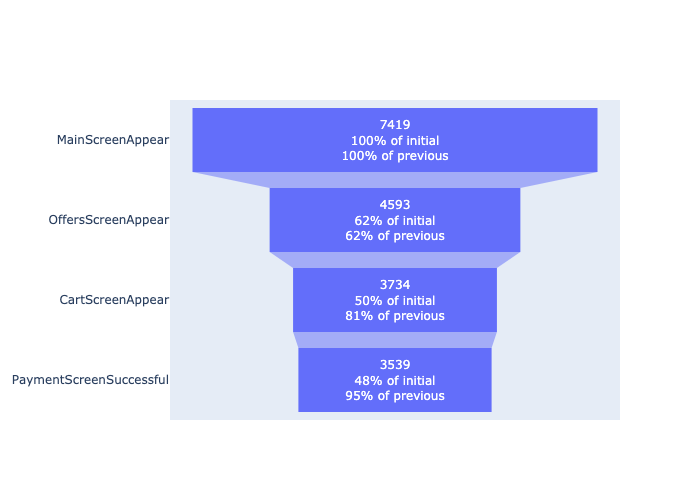

In [31]:
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['users'],
    textinfo = "value+percent initial + percent previous"))
fig.show()

Мы рассчитали, какая доля пользователей доходит до следующего шага воронки и какая доля пользователей доходит от первого события до оплаты. Мы видим, что:
* **Больше всего людей отсеивается после главного экрана.** До экрана с оффером переходит 62% пользователей.
* На следующих шагах мы теряем меньшее количество пользователей. С оффера на корзину переходит 81% пользователей, а с корзины на успешную оплату проходят 95% пользователей.
* **До оплаты с первого шага (с главного экрана) доходит 47,7% пользователей**.

## 5. Изучим результаты эксперимента

**Узнаем, сколько пользователей в каждой экспериментальной группе?**

In [32]:
users = filter_data.groupby('exp_id')['device_id'].nunique()
users['246+247'] = users[246] + users[247] 
users.to_frame()

,device_id
exp_id,
246,2484
247,2513
248,2537
246+247,4997


**У нас есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.**

Критерии успешного A/A-теста:
1. Количество пользователей в различных группах различается не более, чем на 1%;
2. Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
3. Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
4. Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.


In [33]:
# соберем в отдельный датафрэйм информацию по каждой группе и событиям
# добавим долю пользователей, совершивших это событие
events_group = filter_data[filter_data['event_name']!='Tutorial'].pivot_table(index='event_name', columns='exp_id',values='device_id',aggfunc='nunique')\
                          .sort_values(246,ascending=False)
events_group['part_246'] = (events_group[246] / users[246] * 100).round(1)
events_group['part_247'] = (events_group[247] / users[247] * 100).round(1)
events_group['part_248'] = (events_group[248] / users[248] * 100).round(1)
events_group = events_group.reset_index()
events_group

exp_id,event_name,246,247,248,part_246,part_247,part_248
0,MainScreenAppear,2450,2476,2493,98.6,98.5,98.3
1,OffersScreenAppear,1542,1520,1531,62.1,60.5,60.3
2,CartScreenAppear,1266,1238,1230,51.0,49.3,48.5
3,PaymentScreenSuccessful,1200,1158,1181,48.3,46.1,46.6


**Определим, какое событие было самым популярным**

Самое популярное событие - **MainScreenAppear**.\
**Всего 7429 пользователей совершили это дейсвтвие.** В разбивке по группам:
* 246 группа – 2452 пользователей
* 247 группа – 2479 пользователей
* 248 группа – 2498 пользователей

**Посмотрим на долю пользователей**, совершивших это событие в разбивке по группам:
* 246 группа – 98.7% пользователей
* 247 группа – 98.5% пользователей
* 248 группа – 98.3% пользователей

**Проведём z-тест и проверим гипотезу о равенстве групп (246 и 247) или А/А-тест**

Гипотезы:\
H0 - Доли пользователей, совершивших события, в группах 246 и 247 равны.\
H1 - Доли пользователей, совершивших события, в группах 246 и 247 не равны.

**Введём функцию для расчета z-теста, которая будет на вход принимать следующие параметры: 1 группа, 2 группа и уровень статистической значимости**

In [34]:
def z_test (group_1, group_2, alpha):
    for i in events_group.index:
        # пропорция успехов в первой группе:
        p1 = events_group[group_1]/users[group_1]
        # пропорция успехов во второй группе:
        p2 = events_group[group_2]/users[group_2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((events_group[group_1] + events_group[group_2]) / (users[group_1] + users[group_2]))
        
        # разница пропорций в датасетах
        difference = p1 - p2 
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference[i] / mth.sqrt(p_combined[i] * (1 - p_combined[i]) * (1/users[group_1] + 1/users[group_2]))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = stats.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('Для', events_group['event_name'][i], 'p-значение: ', p_value)
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

**Функция готова, переходим к z-тесту для групп 246 и 247**

In [35]:
z_test(246,247,0.01)

Для MainScreenAppear p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Для OffersScreenAppear p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Для CartScreenAppear p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Для PaymentScreenSuccessful p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Мы провели z-тест и результат теста показал, что **статистически значимых различий между долями пользователей в этих группах нет**. Значит, группы сформированны корректно.

**Проведём z-тест и проверим гипотезу о равенстве долей 246 и 248, 247 и 248, а также объединенные группы 246+247 и 248**

Для дальнейшего исследования нам понадобятся результаты объединённой контрольной группы. Добавим столбец в датафрэйм events_group

In [36]:
events_group['246+247'] = events_group[246] + events_group[247]
events_group

exp_id,event_name,246,247,248,part_246,part_247,part_248,246+247
0,MainScreenAppear,2450,2476,2493,98.6,98.5,98.3,4926
1,OffersScreenAppear,1542,1520,1531,62.1,60.5,60.3,3062
2,CartScreenAppear,1266,1238,1230,51.0,49.3,48.5,2504
3,PaymentScreenSuccessful,1200,1158,1181,48.3,46.1,46.6,2358


**A1/B-эксперимент (проверим гипотезу о равенстве долей в группах 246 и 248)**

In [37]:
z_test(246,248,0.05)

Для MainScreenAppear p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Для OffersScreenAppear p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Для CartScreenAppear p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Для PaymentScreenSuccessful p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


z-тест для групп 246 и 248 показал, что статистически значимых различий между долями пользователей нет. 

**A2/B-эксперимент (проверим гипотезу о равенстве долей в группах 247 и 248)**

In [38]:
z_test(247,248,0.05)

Для MainScreenAppear p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Для OffersScreenAppear p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Для CartScreenAppear p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Для PaymentScreenSuccessful p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


z-тест для групп 247 и 248 показал, что статистически значимых различий между долями пользователей в этих группах нет.

**A1+A2/B-эксперимент (проверим гипотезу о равенстве долей в группах 246+247 и 248)**

In [39]:
z_test('246+247',248,0.05)

Для MainScreenAppear p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Для OffersScreenAppear p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Для CartScreenAppear p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Для PaymentScreenSuccessful p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


z-тест для групп 246+247 и 248 показал, что статистически значимых различий между долями в группах нет.

**Мы провели несколько z-тестов: 4 A/A и 16 A/B-тестов.**
* Так как группы A/A-теста должны быть одинаковые, контроль должен быть более строгий. Именно поэтому мы выбрали уровень статистической значимости, равный 1%, при проверке статистических гипотез групп А/А-теста. 
* Для A1/B, A2/B, A1+A2/B-тестов мы выбрали уровень статистической - 5%. Все тесты показали, что статистически значимых различий между долями пользователей в этих группах нет.

## 6. Общие выводы 

Мы провели исследование, чтобы разобраться, как ведут себя пользователи мобильного приложения магазина продуктов питания и какой шрифт для приложения более привлекательный для наших клиентов: привычный или новый. Для теста пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

1. **Мы изучили и проверили данные.** Данные за все даты нам оказались не нужны, так как они были не одинаково полными. Так что мы располагали информацией за одну неделю: 1 - 7 августа 2019 года. Мы проверили и убедились в том, что у нас есть пользователи из всех трёх экспериментальных групп. Они практически равно распределены по группам и нет таких пользователей, которые бы попали в несколько групп одновременно.
2. **Далее мы изучили воронку событий.** В логах оказалось всего 5 событий, которые предположительно идут в таком порядке: Tutorial (обучение) -> MainScreenAppear (главный экран) -> OffersScreenAppear (экран с офферами) -> CartScreenAppear (экран с корзиной) -> PaymentScreenSuccessful (экран с успешной оплатой). Наиболее часто встречающийся – главный экран. Так же мы предположили, что скорее всего туториал показывается только для новых пользователей и, вероятно, его можно не досматривать до конца или просто пролистать. Для расчета воронки обучение считать не стали (при этом не потеряв данные).
3. Мы рассчитали, какая доля пользователей доходит до следующего шага воронки и какая доля пользователей доходит от первого события до оплаты. Выяснили, что:
* **Больше всего людей отсеивается после главного экрана.** До экрана с оффером переходит 62% пользователей.
* На следующих шагах мы теряем меньшее количество пользователей. С оффера на корзину переходит 81% пользователей, а с корзины на успешную оплату проходят 95% пользователей.
* **До оплаты с первого шага (с главного экрана) доходит 47,7% пользователей.**
4. Затем мы провели 4 А1/А2 и 16 А1/А2/В-теста и выяснили, что **статичтически значимых различий между группами нет**.

На основе полученных данных, можно предположить, что **изменение шрифта в мобильном приложении не влияет на поведение пользователей**. Сейчас много пользователей отсеивается на этапе перехода с главного экрана, возможно, этот момент нужно изучить более детально - все ли работает корректно и понятно для пользователя.